# Mixed Layer Depth

In this notebook I'm diving into calculating the mixed layer depth based on the threshold method where the MLD is defined by a density change of $0.03 kg/m^3$ from the surface.

$ z_{mixed layer} = z_{\rho, surface} - z_{\rho, surface - 0.03 kg/m^2}$

Remember that we tried to load all of this information from `Argo_mixedlayers_all_04142022` which has both the threshold and hybrid method MLD for every profile in the Argo database as of April 2022. However, while this dataset has a unique profile number, the data downloaded from argopy does not have a unique identifier. It would probably be possible to match profiles based on the day/time they're collected, however this would likely be much more effor than its worth.

In [64]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [67]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

In [41]:
box_z = xr.open_dataset("202206_boxes/lon:(60,70)_lat:(-60,-55)_ds_z.nc")
box_r = xr.open_dataset("202206_boxes/lon:(60,70)_lat:(-60,-55)_ds_rho.nc")

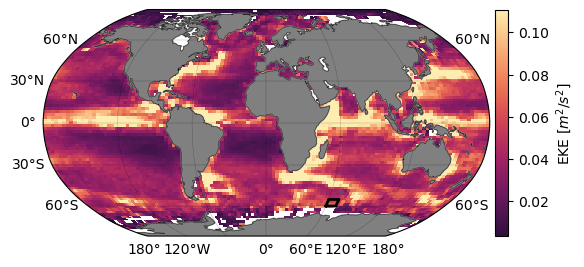

In [4]:
pf.plot_box([[60,70,-60,-55]])

## Write & Test MLD Function

In [5]:
def get_MLD(ds, threshold=0.03,variable='SIG0',dim1='N_PROF',dim2='PRES_INTERPOLATED'):
    MLD_li = []
    
    for n in range(0, len(box_z[dim1])):
        SIG0_surface = box_z.isel({dim1:n})[variable].isel({dim2:0})
        SIG0_diff    = SIG0_surface + threshold
        MLD_ds       = SIG0_surface.where(ds.isel({dim1:n})[variable] < SIG0_diff)
        MLD          = MLD_ds.dropna(dim2).isel({dim2:-1})[dim2].values
        MLD_li.append(MLD)
        
    return ds.assign_coords(MLD=(dim1,MLD_li))

In [6]:
box_z = get_MLD(box_z)

In [7]:
n=5

SIG0_surface = box_z.isel(N_PROF=n).SIG0.isel(PRES_INTERPOLATED=0)
SIG0_diff    = SIG0_surface + 0.03
MLD          = box_z.MLD.isel(N_PROF=n)

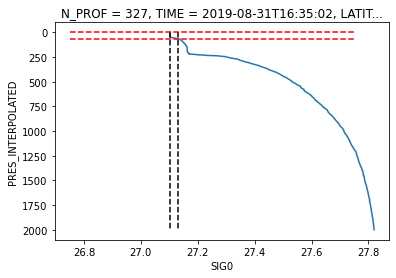

In [8]:
box_z.isel(N_PROF=n).SIG0.plot(y='PRES_INTERPOLATED')
plt.vlines(SIG0_surface,0,2000,linestyle='--',color='k')
plt.vlines(SIG0_diff   ,0,2000,linestyle='--',color='k')
plt.hlines(0,   26.75,27.75,linestyle='--',color='r')
plt.hlines(MLD, 26.75,27.75,linestyle='--',color='r')
plt.gca().invert_yaxis()

In [69]:
box_z = mf.add_times(box_z)

box_zm = box_z.sortby('month_frac')
box_zy = box_z.sortby('year_frac')

In [70]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

Text(0.5, 1.0, 'Fractional Months & Years')

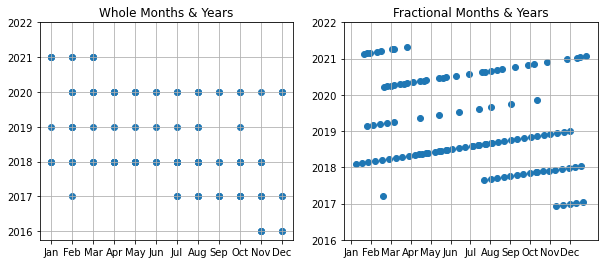

In [71]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(box_z.month,box_z.year)
plt.yticks(range(2016,2023),range(2016,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Whole Months & Years')

plt.subplot(1,2,2)
plt.scatter(box_z.month_frac,box_z.year_frac)
plt.yticks(range(2016,2023),range(2016,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Fractional Months & Years')

These plots make me unreasonably happy. Just very pleasant to look at I think

## Find Max MLD per Bin

In [52]:
MLD_max = np.array([])

for n in range(1,13):
    month_ds = box_z.where(box_z.month<(n+1)).where(box_z.month>(n-1)).dropna('N_PROF')
    MLD      = month_ds.MLD.max()
    MLD_max = np.append(MLD_max,MLD)

In [87]:
MLD_mean = np.array([])

for n in range(1,13):
    month_ds = box_z.where(box_z.month<(n+1)).where(box_z.month>(n-1)).dropna('N_PROF')
    MLD      = month_ds.MLD.mean()
    MLD_mean = np.append(MLD_mean,MLD)

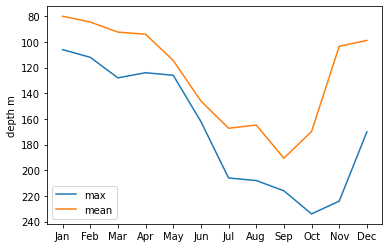

In [92]:
plt.plot(range(1,13),MLD_max,label='max')
plt.plot(range(1,13),MLD_mean,label='mean')
plt.xticks(range(1,13),months)
plt.ylabel('depth m')
plt.gca().invert_yaxis()
plt.legend()

In [94]:
MLD_max - MLD_mean

array([ 26.        ,  27.5       ,  35.63636364,  30.        ,
        11.55555556,  16.        ,  38.72727273,  43.23076923,
        25.42857143,  64.18181818, 120.6       ,  71.14285714])

This can actually be quite a significant difference between the two, especially in November where if we used the mean MLD, at least one profile's MLD would fall below the masked region using a filter scale of 100m. I think this means we should mask from the bottom of MLD_max to exclude the mixed layer impact from every profile.

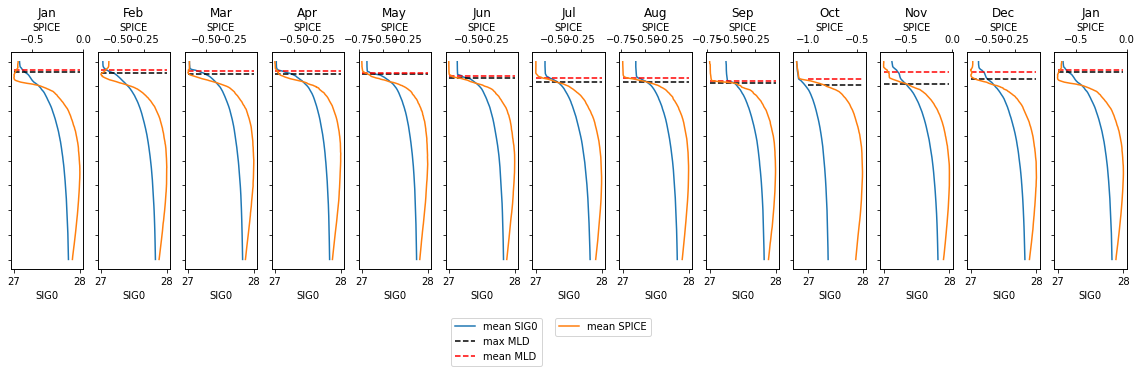

In [125]:
plt.figure(figsize=(20,4))

for n in range(0,12):
    plt.subplot(1,13,n+1)
    box_z.where(box_z.month<n+2).where(box_z.month>n).dropna('N_PROF').SIG0.mean('N_PROF').plot(y='PRES_INTERPOLATED',label='mean SIG0')
    plt.hlines(MLD_max[n],27,28,linestyle='--',color='k',label='max MLD')
    plt.hlines(MLD_mean[n],27,28,linestyle='--',color='r',label='mean MLD')
    plt.ylabel('')
    plt.yticks(ticks=range(0,2001,250),labels=())
    plt.twiny()
    box_z.where(box_z.month<n+2).where(box_z.month>n).dropna('N_PROF').SPICE.mean('N_PROF').plot(y='PRES_INTERPOLATED',label='mean SPICE',color='tab:orange')
    plt.gca().invert_yaxis()
    plt.ylabel('')
    plt.yticks(ticks=range(0,2001,250),labels=())
    plt.title('{}'.format(months[n]))

    
plt.subplot(1,13,13)
box_z.where(box_z.month<2).where(box_z.month>0).dropna('N_PROF').SIG0.mean('N_PROF').plot(y='PRES_INTERPOLATED',label='mean SIG0')
plt.hlines(MLD_max[0],27,28,linestyle='--',color='k',label='max MLD')
plt.hlines(MLD_mean[0],27,28,linestyle='--',color='r',label='mean MLD')
plt.ylabel('')
plt.yticks(ticks=range(0,2001,250),labels=())
plt.legend(bbox_to_anchor=(-7,-0.2))
plt.twiny()
box_z.where(box_z.month<2).where(box_z.month>0).dropna('N_PROF').SPICE.mean('N_PROF').plot(y='PRES_INTERPOLATED',label='mean SPICE',color='tab:orange')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(ticks=range(0,2001,250),labels=())
plt.title('{}'.format(months[0]))
plt.legend(bbox_to_anchor=(-5.5,-0.2))

plt.subplots_adjust(hspace=0.5)

Next step is to apply this framework to the 'bound' keyword found in the EV and filtering functions. Currently, they mask from the surface and bottom boundaries of a profile, but they should mask from the max MLD and bottom instead. I do worry though that this will throw out large sections of the data that we're interested in studying. The rough draft of Steinberg Figure 5 plot shows that a lot of smaller scale variance occurs between 100-500m, and most of that will be masked out due to the MLD boundary.